In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# import sys
# sys.path.insert(0,'/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/notebooks/utils')
# from plots import plot_decision_regions

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

In [2]:
df = pd.read_csv('../raw_data/BankChurners.csv')
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

In [3]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Exploring corelations with heatmap

<AxesSubplot:>

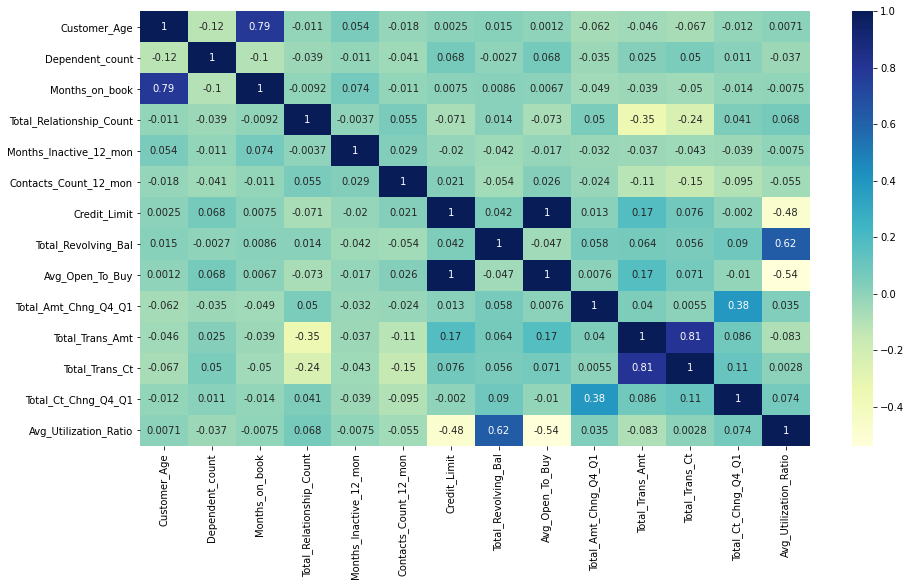

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15,8)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [5]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

In [6]:
corr_df.head(10)

,feature_1,feature_2,correlation
118,Avg_Open_To_Buy,Credit_Limit,0.995981
92,Credit_Limit,Avg_Open_To_Buy,0.995981
151,Total_Trans_Amt,Total_Trans_Ct,0.807192
164,Total_Trans_Ct,Total_Trans_Amt,0.807192
28,Months_on_book,Customer_Age,0.788912
2,Customer_Age,Months_on_book,0.788912
189,Avg_Utilization_Ratio,Total_Revolving_Bal,0.624022
111,Total_Revolving_Bal,Avg_Utilization_Ratio,0.624022
138,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,0.384189
177,Total_Ct_Chng_Q4_Q1,Total_Amt_Chng_Q4_Q1,0.384189


Dropping the `Avg_Open_To_Buy` column because of high corelation with `Credit_Limit`

In [7]:
df.drop('Avg_Open_To_Buy',axis=1, inplace=True)

## Hold-out

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition_Flag', axis=1).copy()
y = df[['Attrition_Flag']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [9]:
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4813,47,M,2,Graduate,Divorced,$80K - $120K,Blue,40,6,1,3,16741.0,1225,0.641,3608,56,0.514,0.073
9887,54,M,1,Unknown,Single,$60K - $80K,Blue,48,4,5,4,4752.0,1230,0.883,15678,103,0.717,0.259
4191,41,F,4,Uneducated,Married,Less than $40K,Blue,33,5,2,3,2888.0,821,0.931,4713,77,1.026,0.284
7527,48,F,3,Graduate,Married,Unknown,Blue,39,3,1,2,6130.0,1741,0.578,4264,63,0.658,0.284
5081,49,M,4,College,Divorced,$120K +,Blue,41,3,1,1,7184.0,1207,0.657,3244,58,1.000,0.168


## Pre-processing function

In [6]:
# Feature encoding

# Mapping
# Target encoding

# Scaling

# Class Imbalance - Not needed

# pipe = Pipeline([
#     ('encoder', OneHotEncoder(sparse=False, drop='if_binary')),
#     ('scaler', StandardScaler())])

def preprocessing(X,y):
    
    #Encodingg gender
    onehot_encoder = OneHotEncoder(sparse=False, drop='if_binary')
    onehot_encoder.fit(X[['Gender']].copy())
    X['Male'] = onehot_encoder.transform(X[['Gender']])
    X.drop(['Gender'], axis=1, inplace=True)
    
    #Encodingg marital status
    onehot_encoder.fit(X[['Marital_Status']])
    X['Status_Divorced'], X['Status_Married'], X['Status_Single'], X['Status_Unknown'] = onehot_encoder.transform(X[['Marital_Status']]).T
    X.drop(['Marital_Status'], axis=1, inplace=True)
    
    #Mapping educational_level
    edu_dict = {'Unknown':2.5, 'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5}
    X['Education_Level'] = X['Education_Level'].map(edu_dict)
    
    #Mapping income_category
    income_dict = {'Unknown':2 , 'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4}
    X['Income_Category'] = X['Income_Category'].map(income_dict)
    
    #Mapping card_category
    card_dict = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}
    X['Card_Category'] = X['Card_Category'].map(card_dict)
    
    #Scaling
    std_scaler = StandardScaler()
    std_scaler.fit(X)
    X_scaled = pd.DataFrame(std_scaler.transform(X))
    X = pd.DataFrame(data=X_scaled.values, columns=X.columns)
    
    #Encoding Attrition_flag
    onehot_encoder.fit(y[['Attrition_Flag']])
    y['Existing Customer'] = onehot_encoder.transform(y[['Attrition_Flag']])
    y.drop('Attrition_Flag', axis=1, inplace=True)
    
    return X, y

In [7]:
X_train, y_train = preprocessing(X_train, y_train)
#X_test, y_test = preprocessing(X_test, y_test)

## Feature encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False, drop='if_binary')

In [ ]:
onehot_encoder.fit(X_train[['Gender']].copy())

In [12]:
onehot_encoder.categories_

[array(['F', 'M'], dtype=object)]

In [13]:
X_train['Male'] = onehot_encoder.transform(X_train[['Gender']])

In [14]:
X_train.drop(['Gender'], axis=1, inplace=True)

In [15]:
onehot_encoder.fit(X_train[['Marital_Status']])

OneHotEncoder(drop='if_binary', sparse=False)

In [16]:
onehot_encoder.categories_

[array(['Divorced', 'Married', 'Single', 'Unknown'], dtype=object)]

In [17]:
X_train['Status_Divorced'], X_train['Status_Married'], X_train['Status_Single'], X_train['Status_Unknown'] = onehot_encoder.transform(X_train[['Marital_Status']]).T
X_train.drop(['Marital_Status'], axis=1, inplace=True)

## Mapping multi-category columns

`Education_Level`

In [18]:
edu_dict = {'Unknown':2.5, 'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5}

In [19]:
X_train['Education_Level'] = X_train['Education_Level'].map(edu_dict)

`Income_Category`

In [20]:
income_dict = {'Unknown':2 , 'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4}

In [21]:
X_train['Income_Category'] = X_train['Income_Category'].map(income_dict)

`Card_Category`

In [22]:
card_dict = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}

In [23]:
X_train['Card_Category'] = X_train['Card_Category'].map(card_dict)

## Target encoding

In [24]:
onehot_encoder.fit(y_train[['Attrition_Flag']])
onehot_encoder.categories_

[array(['Attrited Customer', 'Existing Customer'], dtype=object)]

In [25]:
y_train['Existing Customer'] = onehot_encoder.transform(y_train[['Attrition_Flag']])
y_train.drop('Attrition_Flag', axis=1, inplace=True)

In [26]:
X_train.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Male,Status_Divorced,Status_Married,Status_Single,Status_Unknown
4813,47,2,3.0,3,0,40,6,1,3,16741.0,...,0.641,3608,56,0.514,0.073,1.0,1.0,0.0,0.0,0.0
9887,54,1,2.5,2,0,48,4,5,4,4752.0,...,0.883,15678,103,0.717,0.259,1.0,0.0,0.0,1.0,0.0
4191,41,4,0.0,0,0,33,5,2,3,2888.0,...,0.931,4713,77,1.026,0.284,0.0,0.0,1.0,0.0,0.0
7527,48,3,3.0,2,0,39,3,1,2,6130.0,...,0.578,4264,63,0.658,0.284,0.0,0.0,1.0,0.0,0.0
5081,49,4,2.0,4,0,41,3,1,1,7184.0,...,0.657,3244,58,1.000,0.168,1.0,1.0,0.0,0.0,0.0


## Scaling numerical columns

In [27]:
std_scaler = StandardScaler()

In [28]:
std_scaler.fit(X_train)
X_train_scaled = pd.DataFrame(std_scaler.transform(X_train))
X_train = pd.DataFrame(data=X_train_scaled.values, columns=X_train.columns)
X_train.head()

,Customer_Age,Dependent_count,Education_Level,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Male,Status_Divorced,Status_Married,Status_Single,Status_Unknown
0,0.070596,-0.268854,0.652245,1.218339,-0.246191,0.503428,1.414525,-1.323300,0.486704,0.890409,...,-0.536527,-0.229879,-0.370894,-0.821786,-0.726172,1.058419,3.546624,-0.931779,-0.800937,-0.276084
1,0.949128,-1.040993,0.271397,0.447717,-0.246191,1.512241,0.127801,2.625985,1.383209,-0.428937,...,0.555353,3.313302,1.634726,0.010678,-0.050252,1.058419,-0.281958,-0.931779,1.248537,-0.276084
2,-0.682431,1.275424,-1.632842,-1.093526,-0.246191,-0.379283,0.771163,-0.335979,0.486704,-0.634064,...,0.771925,0.094497,0.525234,1.277828,0.040598,-0.944805,-0.281958,1.073215,-0.800937,-0.276084
3,0.196101,0.503285,0.652245,0.447717,-0.246191,0.377326,-0.515561,-1.323300,-0.409802,-0.277293,...,-0.820776,-0.037308,-0.072185,-0.231269,0.040598,-0.944805,-0.281958,1.073215,-0.800937,-0.276084
4,0.321605,1.275424,-0.109451,1.988961,-0.246191,0.629530,-0.515561,-1.323300,-1.306308,-0.161304,...,-0.464336,-0.336732,-0.285549,1.171207,-0.380944,1.058419,3.546624,-0.931779,-0.800937,-0.276084


## Handling class imbalance using SMOTE

In [14]:
print('Before handling imbalance:\n', y_train.value_counts())
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print('\nAfter handling imbalance:\n', y_train.value_counts())

Before handling imbalance:
 Existing Customer
1.0                  5917
0.0                  1171
dtype: int64

After handling imbalance:
 Existing Customer
0.0                  5917
1.0                  5917
dtype: int64


<AxesSubplot:>

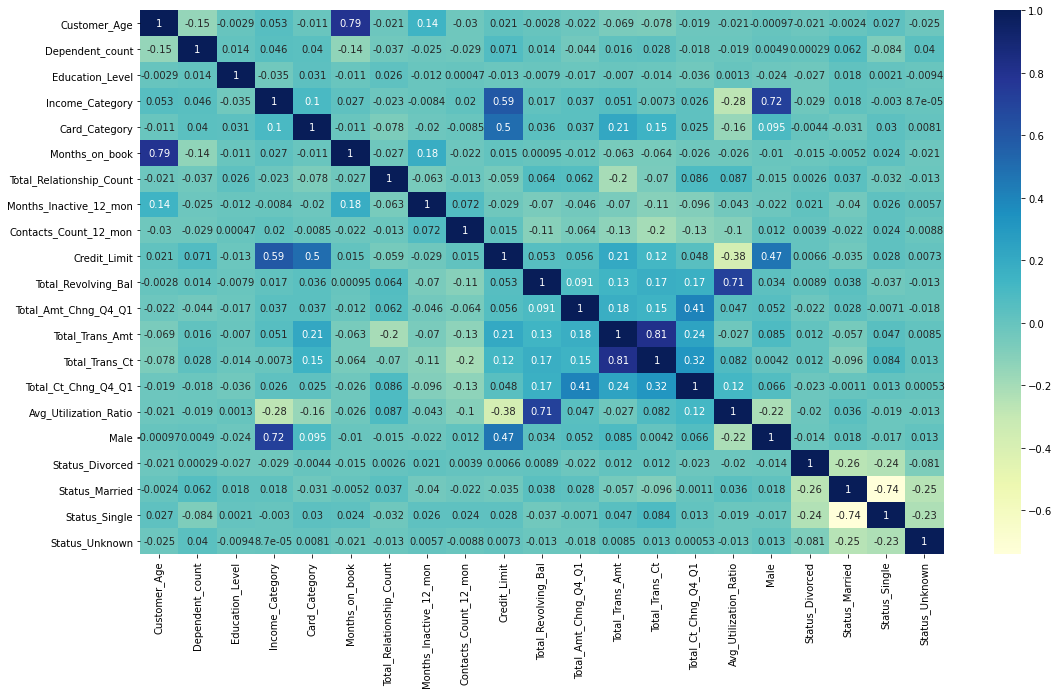

In [30]:
corr = X_train.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [31]:
corr_trained = corr.unstack().reset_index() # Unstack correlation matrix 
corr_trained.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_trained.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_trained = corr_trained[corr_trained['feature_1'] != corr_trained['feature_2']] # Remove self correlation

In [32]:
corr_trained.head(21)

,feature_1,feature_2,correlation
285,Total_Trans_Ct,Total_Trans_Amt,0.810631
265,Total_Trans_Amt,Total_Trans_Ct,0.810631
105,Months_on_book,Customer_Age,0.791405
5,Customer_Age,Months_on_book,0.791405
339,Male,Income_Category,0.717761
79,Income_Category,Male,0.717761
225,Total_Revolving_Bal,Avg_Utilization_Ratio,0.712289
325,Avg_Utilization_Ratio,Total_Revolving_Bal,0.712289
72,Income_Category,Credit_Limit,0.593346
192,Credit_Limit,Income_Category,0.593346


In [8]:
X_test, y_test = preprocessing(X_test,y_test)

## Logistic Regression: Cross Validation

In [9]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

LogisticRegression()

In [10]:
log_cv_results = cross_validate(log_model, X_test, y_test, cv=10, 
                            scoring=['accuracy','recall','precision','f1'])

In [11]:
print('Accuracy:\n', log_cv_results['test_accuracy'].mean())
print('\nRecall\n', log_cv_results['test_recall'].mean())
print('\nPrecision\n', log_cv_results['test_precision'].mean())
print('\nf1:\n', log_cv_results['test_f1'].mean())

Accuracy:
 0.901283220427306

Recall
 0.9647675915117777

Precision
 0.9229335251048244

f1:
 0.943251327565848


## KNN Classifier

In [12]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train,y_train)

KNeighborsClassifier()

In [13]:
knn_cv_results = cross_validate(knn_model, X_test, y_test, cv=10, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [14]:
print('Accuracy:\n', knn_cv_results['test_accuracy'].mean())
print('\nRecall:\n', knn_cv_results['test_recall'].mean())
print('\nPrecision:\n', knn_cv_results['test_precision'].mean())
print('\nf1:\n', knn_cv_results['test_f1'].mean())

Accuracy:
 0.8914071999305195

Recall:
 0.9771572236688515

Precision:
 0.9032005733671216

f1:
 0.9386544313863375


### Grid searching the KNN model

In [15]:
# Instanciate model
knn_model = KNeighborsClassifier()

# Hyperparameter Grid
k_grid = {'n_neighbors' : [2,3,4,5], 'p': [1,2,3]}

# Instanciate Grid Search
grid = GridSearchCV(knn_model, k_grid, n_jobs=-1,  cv = 10)

# Fit data to Grid Search
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5], 'p': [1, 2, 3]})

In [16]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 4, 'p': 1}
0.9106912337739954


Update `knn_cv_results` with the best params.

## SVM

In [17]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [18]:
svm_cv_results = cross_validate(svm_model, X_test, y_test, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [19]:
print('Accuracy:\n', svm_cv_results['test_accuracy'].mean())
print('\nRecall:\n', svm_cv_results['test_recall'].mean())
print('\nPrecision:\n', svm_cv_results['test_precision'].mean())
print('\nf1:\n', svm_cv_results['test_f1'].mean())

Accuracy:
 0.9111522370588745

Recall:
 0.9825753827238242

Precision:
 0.9187172812789262

f1:
 0.9495021109699702


### Grid searching the SVM model

In [51]:
# Instanciate model
svm_model = SVC()

# Hyperparameter Grid
s_grid = {'kernel' : ['linear', 'poly', 'sigmoid'], 'C': [1,10,100]}

# Instanciate Grid Search
svm_grid = GridSearchCV(svm_model, s_grid, n_jobs=-1,  cv = 2)

# Fit data to Grid Search
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 100],
                         'kernel': ['linear', 'poly', 'sigmoid']})

In [52]:
print(svm_grid.best_params_)
print(svm_grid.best_score_)

{'C': 10, 'kernel': 'poly'}
0.93670779111036


In [ ]:
svm_grid.best_estimator_.score(X_test, y_test)

## Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
rf_model_results = cross_validate(rf_model, X_test, y_test, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [22]:
print('Accuracy:\n', rf_model_results['test_accuracy'].mean())
print('\nRecall:\n', rf_model_results['test_recall'].mean())
print('\nPrecision:\n', rf_model_results['test_precision'].mean())
print('\nf1:\n', rf_model_results['test_f1'].mean())

Accuracy:
 0.9470210482961935

Recall:
 0.9879972410897695

Precision:
 0.9516598381377206

f1:
 0.9694410785694266
